In [2]:
from __future__ import print_function
import sqlite3
import pandas as pd
import numpy as np
from sklearn.utils import resample

import seaborn as sns
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt

from io import StringIO

import os
from time import time

In [3]:
def bootstrap(dat, func=np.median):
    ttlSamples = 5000
    subsampleCnt = 100
    
    samples = [None]*ttlSamples
    for i in range(ttlSamples):
        boot = resample(dat, replace=True, n_samples=subsampleCnt)
        samples[i] = func(boot)
    samples = sorted(samples)
    return (samples[125], samples[-125])

def barplot_draw_bootstrap(colNum, minVal, maxVal, center, c='black', text_offset=0):
    """ 
    Annotate barplot with p-values.

    :param colNum: number of left bar to put bracket over
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    """

    lx = center[colNum]

    plt.plot((lx, lx), (minVal, maxVal), c=c)

In [4]:
def query(db_name, select_statement):
    conn = sqlite3.connect(db_name)
    curr = conn.cursor()
    curr.execute(select_statement)
    col_names = [d[0] for d in curr.description]
    return (curr.fetchall(), col_names)
    

In [17]:
# Please update the below with the paths of where your data was generated / saved.
# database_paths = [("/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_%d/database.db", "Quad Exp"), ("/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Control_%d/database.db", "Quad Control"), ]
database_paths = [("experiments/Quad_Experimental_%d/database.db", "Quad Exp"), ("experiments/Quad_Control_%d/database.db", "Quad Control"), ]

dfs = []
t0 = time()
for database_path, name in database_paths:
    # the data from sqlite.
    bestRobotss = []
    for i in range(1, 30):
        print(database_path%i)
        robot_info, names = query(database_path%i, "SELECT * from Generations LEFT OUTER JOIN Robots ON Generations.robot = Robots.id")
        best_robots = pd.DataFrame(robot_info, columns=names)
        bestRobotss += [best_robots]
        
    if len(bestRobotss) != 0:
        df = pd.concat(bestRobotss)
        dfs += [(df, name)]

t1 = time()
print("took:", t1-t0)
print(dfs[0][0].shape)



/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_1/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_2/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_3/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_4/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_5/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_6/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_7/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_8/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_9/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_10/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_11/database.db
/mnt/hgfs/dmatthe1/2019-IROS-private/experiments/Quad_Experimental_12/database.db
/mnt/hgfs/dmatthe1/2019-I

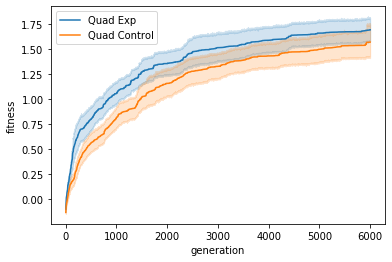

In [31]:
for df, name in dfs:
    sns.lineplot(x="generation", y="fitness", data=df, label=name,  ci=95)
plt.show()

In [27]:
data = {}
for df, name in dfs:
    dat = df[df["generation"]== 6000]

    train_move = np.abs(dat[[d for d in dat.keys() if "forward" in d or "backward" in d]].sum(axis=1))
    train_stop = np.abs(dat[[d for d in dat.keys() if "Train_stop" in d]].sum(axis=1))
    test_stop = np.abs(dat[[d for d in dat.keys() if "Test_stop" in d]].sum(axis=1))
    data[name] = ({"TrainMove":train_move, "TrainStop":train_stop, "TestStop":test_stop})


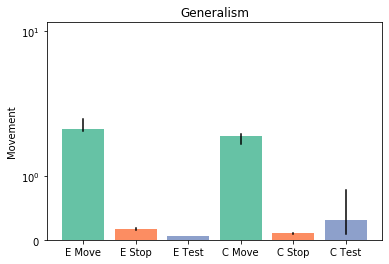

In [30]:
train_move_e = data["Quad Exp"]["TrainMove"]
train_still_e = data["Quad Exp"]["TrainStop"]
test_still_e = data["Quad Exp"]["TestStop"]

train_move_c =  data["Quad Control"]["TrainMove"]
train_still_c =  data["Quad Control"]["TrainStop"]
test_still_c =  data["Quad Control"]["TestStop"]

heights = [np.median(train_move_e),
           np.median(train_still_e),
           np.median(test_still_e),
           np.median(train_move_c),
           np.median(train_still_c),
           np.median(test_still_c)]

bars = np.arange(len(heights))

yerr = (
    bootstrap(train_move_e),
    bootstrap(train_still_e),
    bootstrap(test_still_e),
    bootstrap(train_move_c),
    bootstrap(train_still_c),
    bootstrap(test_still_c)
)


plt.yscale("symlog")
plt.title("Generalism")
plt.ylabel("Movement")


plt.xticks(bars, ("E Move", "E Stop", "E Test", "C Move", "C Stop", "C Test"))
plt.ylim((0, 12))
plt.bar(bars, heights, align='center', color=plt.cm.get_cmap("Set2")([x%3/6 for x in range(6)]))

for j in range(6):
    minV, maxV = yerr[j]
    barplot_draw_bootstrap(j, minV, maxV, bars)
plt.show()